# SageMaker Studioで深層学習モデルの学習を加速・コスト最適化する

データ量が増えてきて、深層学習モデルの学習に時間がかかりすぎていませんか？

このノートブックでは、深層学習モデルの学習にかかる時間とコストを最適化する手順を、SageMaker Data Parallelism LibraryとSageMaker Debuggerを使いながらご紹介します。

SageMaker Data Parallelism Libraryは、AWS上での分散学習実行に最適化されているため、HorovodやPyTorch DDPなどの他の分散学習フレームワークに比べて並列化効率がより高いことが証明されています。

今回は、例としてMask RCNNモデルに[COCO2017データセット](https://cocodataset.org/#home)をゼロから学習するのにかかる時間とコストのトレードオフを見ていきます。

なお、このノートブックはSageMaker Studio上のPython 3 (PyTorch 1.6 Python 3.6 GPU Optimized)環境で動作確認をしております。

他のフレームワークやモデルでの分散学習のスクリプトは[こちら](https://github.com/HerringForks/DeepLearningExamples)を参照してください。

## 学習時間と課金額のトレードオフでトータルコスト最適化を考える

SageMaker上で分散学習を実施することで、時間とお金のトレードオフがコントロールできるようになります。

インスタンスの使用料金をPドル/時、学習にかかる時間をT時間、並列化効率(インスタンス x個で学習時間がx倍にどれくらい近くなるか)をS%として、１個のインスタンス（またはGPU）からN個のインスタンス（またはGPU）に分散学習する場合を考えてみましょう。

学習にかかる時間はT時間から(T/N)/S時間に減り、インスタンス使用料金はT * Pドルから(T/N)/S * P * N = T/S * Pドルへ（S = 1、すなわち並列化効率100%とならない限りは）増加します。並列化効率が十分高ければ、<strong>大幅な学習時間短縮を少ない金額の増加で買うことができる</strong>、というわけです。コストを時間とお金と捉えると、分散学習が１つのコスト最適化のツールとなり、かつ並列化効率がそのトレードオフを決定する重要な要因であることがご理解いただけると思います。

例えば、ml.p3.2xlargeインスタンスで24時間学習に時間を取られている場合、8つのインスタンスに90%の並列化効率で分散学習が実現できれば、時間と課金額は以下のように変化します。

分散学習なしでは24 * 3.825 = 91.8ドル（us-west-2リージョンで[SageMaker Savings Plan](https://aws.amazon.com/about-aws/whats-new/2021/04/amazon-sagemaker-announces-a-price-reduction-in-instances-and-sagemaker-savings-plan/)を使用しない場合）の課金と24時間というコストが発生します。

上記の条件で分散学習をすると、24/0.9 * 3.825 = 102ドルの課金と24/8/0.9 = 3.33時間というコストになります。

<strong>約11%の金額増加で約86%も学習時間を短縮できる</strong>のです。どちらのトータルコストが良いかどうかは、ビジネス上で深層学習のモデル学習時間短縮がどれくらい重要かによります。しかし、モデルを何度も再学習する必要に迫られる中で、これからデータ量が増えていくことが予測されるならば、分散学習を１つの選択肢として持っておくのは悪くないかもしれません。

※この例だと、ml.p3.2xlargeインスタンスを８個のインスタンスにスケールアウトする他に、8個のGPUをもつp3.16xlargeインスタンスを1個使うという方法もあります。これも同様に今回紹介する分散学習の手法としては変わりません。SageMaker Data Parallel Libraryでサポートされているインスタンスはml.p3.16xlarge, ml.p3dn.24xlarge, ml.p4d.24xlargeです。

### 分散学習すべきかを判断するには並列化効率が鍵

分散学習をする上で、鍵となるのは並列化効率です。どのくらいの並列化効率があれば、

実際に現在の深層学習モデルの学習にかかっている時間とインスタンスの料金をもとに、トータルコストをシミュレーションしてみましょう。

SageMakerインスタンスの料金は[こちら](https://aws.amazon.com/jp/sagemaker/pricing/?nc1=h_ls)を参照してください。

これで目指すべき並列化効率が求められます。

In [245]:
import numpy as np
import matplotlib.pyplot as plt

def before_total_cost(T, P, weight):
    # トータルコスト = お金 + 時間
    return T * P + T * weight

def after_total_cost(T, P, N, weight, S):
    return T/S * P + T/N/S * weight

def plot_simulation(T, P, N, weight):
    '''
    横軸: 並列化効率
    縦軸: トータルコスト（ドル）
    分散学習をする場合、最低でもどのくらいの並列化効率が必要かをグラフから目安をつける
    '''
    # 並列化効率を10% ~ 100%までシミュレーション
    scaling_efficiencies = list(np.arange(0.10, 1.01, 0.01))
    
    before = []
    after = []
    for S in scaling_efficiencies:
        before_cost = before_total_cost(T, P, weight)
        before.append(before_cost)
        after_cost = after_total_cost(T, P, N, weight, S)
        after.append(after_cost)
        if round(S*100) % 10 == 0:
            is_cost_lower = after_cost < before_cost
            cost_diff = abs((after_cost - before_cost) / before_cost) * 100
            up = "上がる"
            down = "下がる"
            print(f"並列化効率 {S*100:.1f}%でトータルコストは{cost_diff:.3f}% {down if is_cost_lower else up}")
    print()
    plt.xlabel("Scaling Efficiency")
    plt.ylabel("Total Cost ($)")
    plt.plot(scaling_efficiencies, before, label="before")
    plt.plot(scaling_efficiencies, after, label="after")
    plt.legend()

In [246]:
# 学習に何時間かかっているか
TRAINING_TIME = 24

# インスタンスに時間あたり何ドルかかっているか
INSTANCE_PRICE = 3.825

# 何個インスタンスを使うか
NUM_INSTANCES = 8

# １時間学習が長くなることによる機会費用 (トータルコストをドルで統一するため)
TIME_VALUE = 3

並列化効率 10.0%でトータルコストは515.385% 上がる
並列化効率 20.0%でトータルコストは207.692% 上がる
並列化効率 30.0%でトータルコストは105.128% 上がる
並列化効率 40.0%でトータルコストは53.846% 上がる
並列化効率 50.0%でトータルコストは23.077% 上がる
並列化効率 60.0%でトータルコストは2.564% 上がる
並列化効率 70.0%でトータルコストは12.088% 下がる
並列化効率 80.0%でトータルコストは23.077% 下がる
並列化効率 90.0%でトータルコストは31.624% 下がる
並列化効率 100.0%でトータルコストは38.462% 下がる



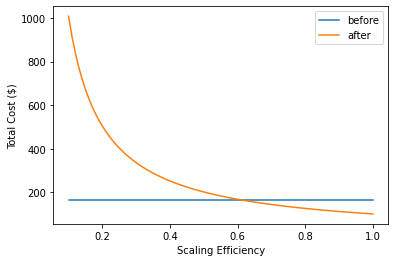

In [247]:
plot_simulation(T=TRAINING_TIME, P=INSTANCE_PRICE, N=NUM_INSTANCES, weight=TIME_VALUE)

1時間学習時間が長くなることで平均３ドルほどの機会費用が発生すると仮定してみる (`TIME_VALUE = 3`) と、8つのインスタンスを使って並列化効率が約60%より大きければ、トータルコスト削減に繋がります。

## 0. 準備と注意点

- SageMaker Data Parallel Libraryを使用する場合、ml.p3.16xlarge, ml.p3dn.24xlarge [推奨], ml.p4d.24xlarge [推奨]の３種類のインスタンスに対応しています。必要に応じて、上限申請をしてください。

- このデモは高性能GPUを搭載したp3インスタンスを使用するため、課金が発生します。
    - 参考: 1つのp3.16xlargeインスタンスを使う場合、リージョンによって20-30ドルほど
    - 1000イテレーションまでの学習にとどめているため、45分以内には学習が完了する設定になっておりますが、ご注意ください。

- このデモはSageMaker Studio上で実行してください。

- このデモは以下のIAM権限が必要です。SageMaker Studioのユーザーがこの権限を持っていることを確かめて進めてください。


In [ ]:
%%time
import sys
! {sys.executable} -m pip install --upgrade sagemaker
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import boto3

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
fsx_client = boto3.client('fsx')

role = get_execution_role() # provide a pre-existing role ARN as an alternative to creating a new role
print(f'SageMaker Execution Role:{role}')

client = boto3.client('sts')
account = client.get_caller_identity()['Account']
print(f'AWS account:{account}')

session = boto3.session.Session()
region = session.region_name
print(f'AWS region:{region}')

## 1. COCO2017データセットの準備

[COCO2017](https://cocodataset.org/#home)のデータセットをこのセッションに付随するS3のバケットにダウンロードします。

このスクリプトは20分ほど実行に時間がかかります。

In [ ]:
%%time
!bash ./upload_coco2017_to_s3.sh {bucket} fsx_sync/train-coco/coco

## 2. SageMakerの実行環境を準備

1. デフォルトでSageMakerは最新のPyTorch学習用イメージを[Amazon Deep Learning Container Images (DLC)](https://github.com/aws/deep-learning-containers/blob/master/available_images.md)から使用します。今回は、これをベースイメージとして、MaskRCNNモデルを学習するのに必要な追加のモジュールをインストールしていきます。
2. PyTorch-SMDataParallel MaskRCNN学習スクリプトがGitHubレポジトリ https://github.com/HerringForks/DeepLearningExamples.git からダウンロードでき、今回はこれを学習用イメージの上にインストールします。

### 2.1. Dockerイメージをビルド・ECRへプッシュ

以下のコマンドを実行して、DockerイメージをビルドしてECRへプッシュしてみましょう。

In [ ]:
image = "mask-rcnn-smdataparallel-demo"  # 例: mask-rcnn-smdataparallel-sagemaker
tag = "test0.1"   # 例: pt1.8

In [ ]:
!pygmentize ./Dockerfile

In [ ]:
!pygmentize ./build_and_push.sh

In [ ]:
# SageMaker Studio上でDocker buildを行うためのモジュールをインストール
! pip install sagemaker-studio-image-build

In [ ]:
%%time
! sm-docker build . -t {image} -f ./Dockerfile --repository {image}:{tag} --build-arg region={region}

# sm-dockerがうまく機能しない場合は、Dockerが使用できる別環境（SageMaker Notebook instanceなど）を使用してdocker buildしてECRへイメージをプッシュしてください。
# Dockerfileとbuild_and_push.shを参照してください。
# ! chmod +x build_and_push.sh; bash build_and_push.sh {region} {image} {tag}

In [ ]:
# 学習のベースとなるモデルファイルをダウンロードする
!wget https://dl.fbaipublicfiles.com/detectron/ImageNetPretrained/MSRA/R-50.pkl 
!aws s3 cp R-50.pkl s3://{bucket}/pretrained_weights/R-50.pkl

### 2.2. 学習時に収集するメトリクスを定義する

学習ジョブの状態をよく把握するために、アルゴリズムに対するメトリクスを定義します。

以下のように正規表現でフィルターをかけ、追跡したいメトリクスを特定してください。今回はモデルの精度は確認しませんが、SageMaker Studio上で学習ジョブの詳細を確認するとこれらのメトリクスが表示されます。

In [ ]:
metric_definitions=[{
        "Name": "loss",
        "Regex": ".*loss:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_classifier",
        "Regex": ".*loss_cls:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_box_reg",
        "Regex": ".*loss_box_reg:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_mask",
        "Regex": ".*loss_mask:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_objectness",
        "Regex": ".*loss_objectness:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_rpn_box_reg",
        "Regex": ".*loss_rpn_box_reg:\s([0-9\\.]+)\s*"
    }, 
    {
        "Name": "overall_training_speed",
        "Regex": ".*Overall training speed:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "lr",  
        "Regex": ".*lr:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "iter",  
        "Regex": ".*iter:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "avg iter/s",  
        "Regex": ".*avg iter/s:\s([0-9\\.]+)\s*"
    },
]

## 3. 複数GPUを持つインスタンス１つで学習する場合

`Estimator`というクラス（を継承した`PyTorch`クラス）に対して、学習ジョブで使うインスタンスの種類と数を選びます。ここでは、まずはml.p3.16xlargeインスタンス１つ（8つのGPU）で1000イテレーションしてみて、どのくらいの時間がかかるかみてみましょう。

学習用スクリプトは`train_pytorch_single_maskrcnn.py`ファイルを参照してください。まだ学習スクリプト内でSageMaker Distributed Data Parallel Libraryをimportする必要はありませんが、１つのインスタンスに含まれる複数GPUを活用するため`PyTorch`オブジェクトに`distribution`の引数を設定しておく必要があります。

ここで大切なのは、ロスが収束しているかを現時点では気にしないことです。分散学習をする際は、まずは速くイテレーションを回すことができることを確認した上で、必要なモデル精度を出すためにバッチサイズや学習率などのチューニングを行ってください。これは、小さなスケールで最適なパラメータも、スケールを大きくすると別のパラメータが最適になる場合があるからです。

In [ ]:
import os
import time
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig

In [ ]:
# SageMaker Debuggerを活用するため
profiler_config = ProfilerConfig(system_monitor_interval_millis=500)

In [ ]:
# ml.p3.16xlarge, ml.p3dn.24xlarge, ml.p4d.24xlargeのみ利用可能です
instance_type = "ml.p3.16xlarge"
# ここではまず１つのインスタンスで試す
instance_count = 1
# ビルドしたイメージのURIを取得します
docker_image = f"{account}.dkr.ecr.{region}.amazonaws.com/{image}:{tag}"
username = 'AWS'
job_name = f'single-p3-16xlarge-{int(time.time())}'
# このyamlファイルでバッチサイズやイテレーションの長さを定義しています
# YACSで設定管理をしています: https://github.com/rbgirshick/yacs
config_file = 'e2e_mask_rcnn_R_50_FPN_1x_16GPU_4bs.yaml'

In [ ]:
hyperparameters = {
 "config-file": config_file,
 "skip-test": "",
 "seed": 987,
 "dtype": "float16",
 "spot_ckpt":f"s3://{bucket}/pretrained_weights/R-50.pkl"
}

In [ ]:
estimator = PyTorch(entry_point='train_pytorch_single_maskrcnn.py',
                    role=role,
                    image_uri=docker_image,
                    source_dir='.',
                    instance_count=instance_count,
                    instance_type=instance_type,
                    framework_version='1.8.0',
                    py_version='py36',
                    sagemaker_session=sagemaker_session,
                    metric_definitions = metric_definitions,
                    hyperparameters=hyperparameters,
                    # プロファイリングには必須の設定！
                    profiler_config=profiler_config,
                    # 複数GPUを持つml.p3.16xlargeを有効活用するために
                    # distribution戦略を設定する必要があります
                    distribution={'smdistributed':{
                                    'dataparallel':{
                                            'enabled': True
                                         }
                                      }
                                  }
                   )

In [ ]:
train_s3 = f's3://{bucket}/fsx_sync/train-coco/coco/'
data_channels = { 'train': train_s3 }

In [ ]:
estimator.fit(inputs=data_channels, job_name=job_name, wait=False)

### 3.1 SageMaker Debuggerでプロファイリングする

![](images/sm_debugger_nav.png)

SageMaker Studio左側のメニューにある一番下のアイコンから、該当する学習ジョブを探して、右クリックをして「Open Debugger for Insights」を選択すると、プロファイラーの（途中）結果を確認することができます。

![](images/sm_debugger_insights.png)

Insightsを確認すると、自動生成されたプロファイリングレポートが見れ、CPU、IO、バッチサイズ、GPUメモリなどのボトルネックを探すのに役立ちます。

![](images/sm_debugger_sys_util.png)

Nodesタブをクリックすると、学習中にどれくらいCPUとGPUを使用できていたかが可視化できて便利です。今回の場合、S3からデータをダウンロードするのに待ち時間が生じて、CPUとGPUが効率的に活用できていないことが伺えます。

## 4. 複数GPUを持つインスタンス複数で学習する場合

`train_pytorch_single_maskrcnn.py`と`train_pytorch_smdataparallel_maskrcnn.py`を比べて、通常の学習スクリプトを分散学習用に書き換える部分を確認してください。

ポイントとしては以下の３つです。

1. SageMaker Data Parallel Libraryをimportする

```python
from smdistributed.dataparallel.torch.parallel.distributed import DistributedDataParallel as DDP
import smdistributed.dataparallel.torch.distributed as dist
# ここでプロセスの初期化を行います
dist.init_process_group()
```

2. モデルを`DistributedDataParallel`に渡す

```python
model = DDP(model, device_ids=[dist.get_local_rank()], broadcast_buffers=False)
```

3. ログは１つのインスタンスが代表して出力する

通常、以下のように、`rank == 0`となるインスタンスを代表として定め、ログを出力させる。
```python
if dist.get_rank() ==0:
        map_results, raw_results = results[0]
        bbox_map = map_results.results["bbox"]['AP']
        segm_map = map_results.results["segm"]['AP']
    else:
        bbox_map = 0.
        segm_map = 0.
```

## 5. Amazon FSx for Lustreを使ってデータダウンロードとIOを加速する

こうしたダウンロードによる待ち時間の発生を軽減させるために、AWSのファイルシステムにデータを保存して、学習インスタンスにファイルシステムをマウントすることで合計学習時間を短縮できます。Amazon Elastic File System (EFS) またはAmazon FSx for Lustreを活用できます。今回はAmazon FSx for Lustreを使います。

これも先ほどと同様、使用料金とダウンロードにかかる時間を短縮することによるトレードオフで、ファイルシステムのマウントが必要か検討してください。

Amazon EFSの料金は[こちら](https://aws.amazon.com/jp/efs/pricing/?nc1=h_ls)、Amazon FSx for Lustreの料金は[こちら](https://aws.amazon.com/jp/fsx/lustre/pricing/)を参照してください。

FSx for Lustreを使用するには、VPCサブネットとセキュリティグループを設定しておく必要があります。
学習用インスタンスがファイルシステムをマウントできるように、セキュリティグループはポート988番を自身のセキュリティグループに向けて開けておく様に注意して下さい。

In [ ]:
subnet=['<YOUR_SUBNET>'] # VPC内のサブネット１つ
security_group_ids=['<SECURITY_GROUP_WITH_PORT_988_OPEN>']

In [ ]:
# use boto3 to create FSx
fsx_response = fsx_client.create_file_system(
      FileSystemType='LUSTRE',
      StorageCapacity=1200,
      StorageType='SSD',
      SubnetIds= subnet,
      SecurityGroupIds= security_group_ids,
      Tags=[
          {
              'Key': 'Name',
              'Value': 'COCO-storage'
          },
      ],
      LustreConfiguration={
          'WeeklyMaintenanceStartTime': '7:03:00',
#           'ImportPath': f's3://{bucket}/fsx_sync/', # where FSx will import data from in s3, can do entire bucket or a specific folder
          'ImportPath': f's3://{bucket}/fsx_sync/train-coco/coco/',
          'ImportedFileChunkSize': 1024,
          'DeploymentType': 'PERSISTENT_1', # |'SCRATCH_1' |'SCRATCH_2' # PERSISTENT means the storage in FSx will be persistent, SCRATCH indicates the storage is temporary
          'AutoImportPolicy': 'NEW', # 'NONE'| |'NEW_CHANGED' # this policy is how often data will be imported to FSx from S3
          'PerUnitStorageThroughput':200 # this is specific to PERSISTENT storage, not required for temporary
      }
  )

fsx_response

In [ ]:
file_system_id = fsx_response['FileSystem']['FileSystemId'] # FSx file system ID with your training dataset. Example: 'fs-0bYYYYYY'
mount_name = fsx_response['FileSystem']['LustreConfiguration']['MountName']

In [ ]:
estimator = PyTorch(entry_point='train_pytorch_smdataparallel_maskrcnn.py',
                    role=role,
                    image_uri=docker_image,
                    source_dir='.',
                    instance_count=instance_count,
                    instance_type=instance_type,
                    framework_version='1.8.0',
                    py_version='py36',
                    sagemaker_session=sagemaker_session,
                    metric_definitions = metric_definitions,
                    hyperparameters=hyperparameters,
                    subnets=subnet,
                    security_group_ids=security_group_ids,
                    profiler_config=profiler_config,
                    distribution={'smdistributed':{
                                    'dataparallel':{
                                            'enabled': True
                                         }
                                      }
                                  }
           )

In [ ]:
# Configure FSx Input for your SageMaker Training job

from sagemaker.inputs import FileSystemInput
file_system_directory_path = f'/{mount_name}/fsx_sync/train-coco/coco'
file_system_access_mode = 'ro'
file_system_type = 'FSxLustre'
train_fs = FileSystemInput(file_system_id=file_system_id,
                            file_system_type=file_system_type,
                            directory_path=file_system_directory_path,
                            file_system_access_mode=file_system_access_mode)
data_channels = {'train': train_fs}

In [ ]:
# Submit SageMaker training job
job_name = f'pytorch-smdataparallel-mrcnn-fsx-{int(time.time())}'
estimator.fit(inputs=data_channels, job_name=job_name, wait=False)

## 最後に
同様にSageMaker Debugger Insightsを見て、プロファイリングの結果を確認してみてください。学習時間が短縮されているのがわかるはずです。

適宜Suggestionsに従って、バッチサイズ、学習率やインスタンスタイプとその数を調整してください。

同時に、よりIO効率の良いTFRecordやMXNet RecordIOなどのデータフォーマットへの変換や、LARSをはじめとした分散学習時の学習率スケージュリング、Mixed Precision学習などのテクニックを用いて、学習時間を短縮するための実験を繰り返して下さい。このデモを通じて、SageMakerをフル活用することで、その実験サイクルをより早く回せるのがご理解いただけたかと思います。
